# Forecasting Regional Influenza Activity Using Global Panel Models
>Time Series Forecasting Project

**Objective**

The objective of this project is to build accurate, short-term forecasting models for weekly influenza-like illness (ILI) activity across all ten U.S. HHS regions. The goal is to compare classical time-series approaches (SARIMA) with modern machine-learning panel models (Random Forest) and evaluate their ability to capture seasonal dynamics, structural breaks, and regional differences.

## Problem Statement

Seasonal influenza creates recurring pressure on healthcare systems, requiring early and reliable forecasting tools for resource allocation. Public health authorities depend on timely forecasts to anticipate staffing needs, vaccine distribution, hospital load, and communication strategy.

This project addresses the following forecasting question:

>Can we accurately predict next-week influenza activity (ILI%) for each U.S. HHS region using historical flu surveillance data, seasonal indicators, and laboratory positivity rates?

The modeling challenge includes:

strong yearly seasonality,

highly persistent autoregressive structure,

region-specific amplitude differences,

structural breaks during the COVID period,

and the need for robust out-of-sample performance.

We evaluate several modeling frameworks, from naive seasonal baselines to SARIMA and global machine-learning models.

## Dataset Description

## Dataset Overview

The dataset is a merged panel of weekly influenza surveillance data covering:

- 10 U.S. HHS regions  
- Weekly frequency  
- From October 1997 to November 2025  
- 1,467 observations per region  
- ~14,670 total rows after cleaning and lag creation  

---

## Key Variables

| Variable | Description |
|---------|-------------|
| `'ILI_PERCENT'` | Percentage of outpatient visits due to influenza-like illness |
| `'PERCENT_POSITIVE'`, `'TOTAL_SPECIMENS'` | Laboratory-confirmed influenza activity |
| `'PERCENT_A'`, `'PERCENT_B'` | Share of Influenza A/B among positive tests |
| `'DATE'`, `'YEAR'`, `'WEEKOFYEAR'` | Temporal indicators |
| `'REGION'` | HHS region label |
| `'REGION_ID'` | Encoded region ID for ML models |
| `'ILI_PERCENT_lag1'` … `'ILI_PERCENT_lag52'` | Autoregressive lag structure |
| `'PERCENT_POSITIVE_lag1'` … `'PERCENT_POSITIVE_lag52'` | Exogenous lag structure |

---

## Data Quality Summary

- Complete regional coverage across 28 years  
- Fixed weekly frequency with no gaps  
- Age-stratified ILI fields dropped due to >35% missingness  
- Lab positivity interpolated within regions for early sparse years  
- All forecasting features numeric and clean  

---

## Suitability for Forecasting

The dataset’s long time span and uniform panel structure make it suitable for:

- Region-by-region SARIMA modeling  
- Global panel machine-learning approaches  
- Seasonal decomposition  
- Robust train/validation/test forecasting evaluation  


## **Data Import & Memory Optimization**

In [1]:
# --- Installations ---
!pip install -q keras-tuner missingno plotly seaborn matplotlib scikit-learn tensorflow joblib pyarrow fsspec shap optuna catboost duckdb numpy

# --- Core Python & Utilities ---
import gc
import json
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # optional but used in EDA if needed

# --- Time-Series Tools ---
import statsmodels.api as sm

# --- Machine Learning ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# --- Missing Data Visualization ---
import missingno as msno

# --- Optional (if using LightGBM) ---
# import lightgbm as lgb

# --- System Settings ---
pd.set_option('display.max_columns', 200)
sns.set_style("whitegrid")


## 1. Data Exploration & Preparation

### 1.1 Load & Inspect Dataset

In [2]:
df = pd.read_csv("flu_merged.csv", parse_dates=["DATE"])

In [3]:
print(df.head())
print(df.dtypes)
print("\nRegions:", df["REGION"].unique())
print("\nTime span:", df["DATE"].min(), "→", df["DATE"].max())
print("\nWeekly frequency check (per region):")
print(df.groupby("REGION")["DATE"].agg(["min", "max", "count"]))

     REGION  YEAR  WEEK       DATE  TOTAL_SPECIMENS  TOTAL_A  TOTAL_B  \
0  Region 1  1997    40 1997-10-06               51      0.0      0.0   
1  Region 1  1997    41 1997-10-13               54      0.0      0.0   
2  Region 1  1997    42 1997-10-20               43      0.0      0.0   
3  Region 1  1997    43 1997-10-27               56      0.0      0.0   
4  Region 1  1997    44 1997-11-03               60      0.0      0.0   

   PERCENT_POSITIVE  PERCENT_A  PERCENT_B  REGION_TYPE  ILI_PERCENT  \
0               0.0        0.0        0.0  HHS Regions     0.498535   
1               0.0        0.0        0.0  HHS Regions     0.642669   
2               0.0        0.0        0.0  HHS Regions     2.899080   
3               0.0        0.0        0.0  HHS Regions     4.812500   
4               0.0        0.0        0.0  HHS Regions     1.371360   

   %UNWEIGHTED_ILI  AGE_0-4  AGE_25-49  AGE_25-64  AGE_5-24  AGE_50-64  \
0         0.623848       15        NaN        7.0        22 

The merged dataset is well structured, covering weekly influenza surveillance for all 10 HHS regions from October 1997 to November 2025. All regions share the same start and end dates with no missing weekly entries, resulting in 1,467 observations per region. This uniform panel structure is ideal for both classical time-series models (e.g., SARIMA) and modern global forecasting approaches (e.g., Random Forest, LightGBM). Key indicators such as ILI percentages, specimen counts, and lab positivity rates are correctly typed and show realistic patterns, with limited missingness concentrated in early years.

### 1.2 Missing Values & Distribution Check

AGE_25-64             0.572597
AGE_50-64             0.362645
AGE_25-49             0.362645
PERCENT_POSITIVE      0.074710
PERCENT_A             0.074710
PERCENT_B             0.074710
REGION                0.000000
AGE_0-4               0.000000
NUM__OF_PROVIDERS     0.000000
ILI_TOTAL_PATIENTS    0.000000
AGE_65                0.000000
AGE_5-24              0.000000
ILI_PERCENT           0.000000
%UNWEIGHTED_ILI       0.000000
YEAR                  0.000000
REGION_TYPE           0.000000
TOTAL_B               0.000000
TOTAL_A               0.000000
TOTAL_SPECIMENS       0.000000
DATE                  0.000000
WEEK                  0.000000
TOTAL_PATIENTS        0.000000
dtype: float64


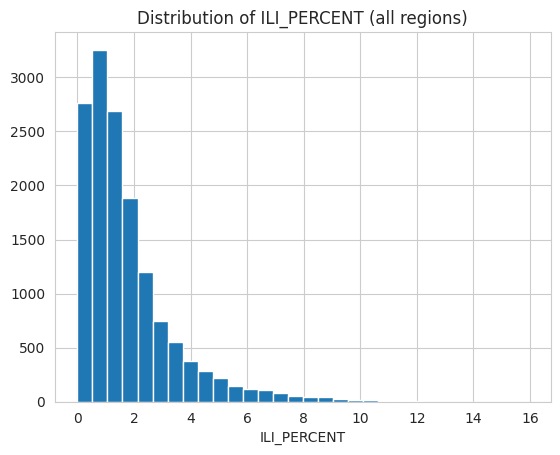

In [4]:
# Missing values
na_ratio = df.isna().mean().sort_values(ascending=False)
print(na_ratio)

# Distribution check
df["ILI_PERCENT"].hist(bins=30)
plt.title("Distribution of ILI_PERCENT (all regions)")
plt.xlabel("ILI_PERCENT")
plt.show()


In [5]:
age_cols = [c for c in df.columns if c.startswith("AGE_")]
df = df.drop(columns=age_cols)


Age-specific ILI variables exhibit high missingness (36–57%) due to their later introduction into FluView reporting, and were therefore excluded from feature construction. Laboratory positivity indicators show moderate missingness (~7%), concentrated in early years, and were smoothed via within-region interpolation. All primary surveillance variables, including ILI_PERCENT, specimen counts, and outpatient visit statistics, are fully complete, allowing for stable time-series modeling and reliable lag feature generation.

### 1.3 Time plots per region

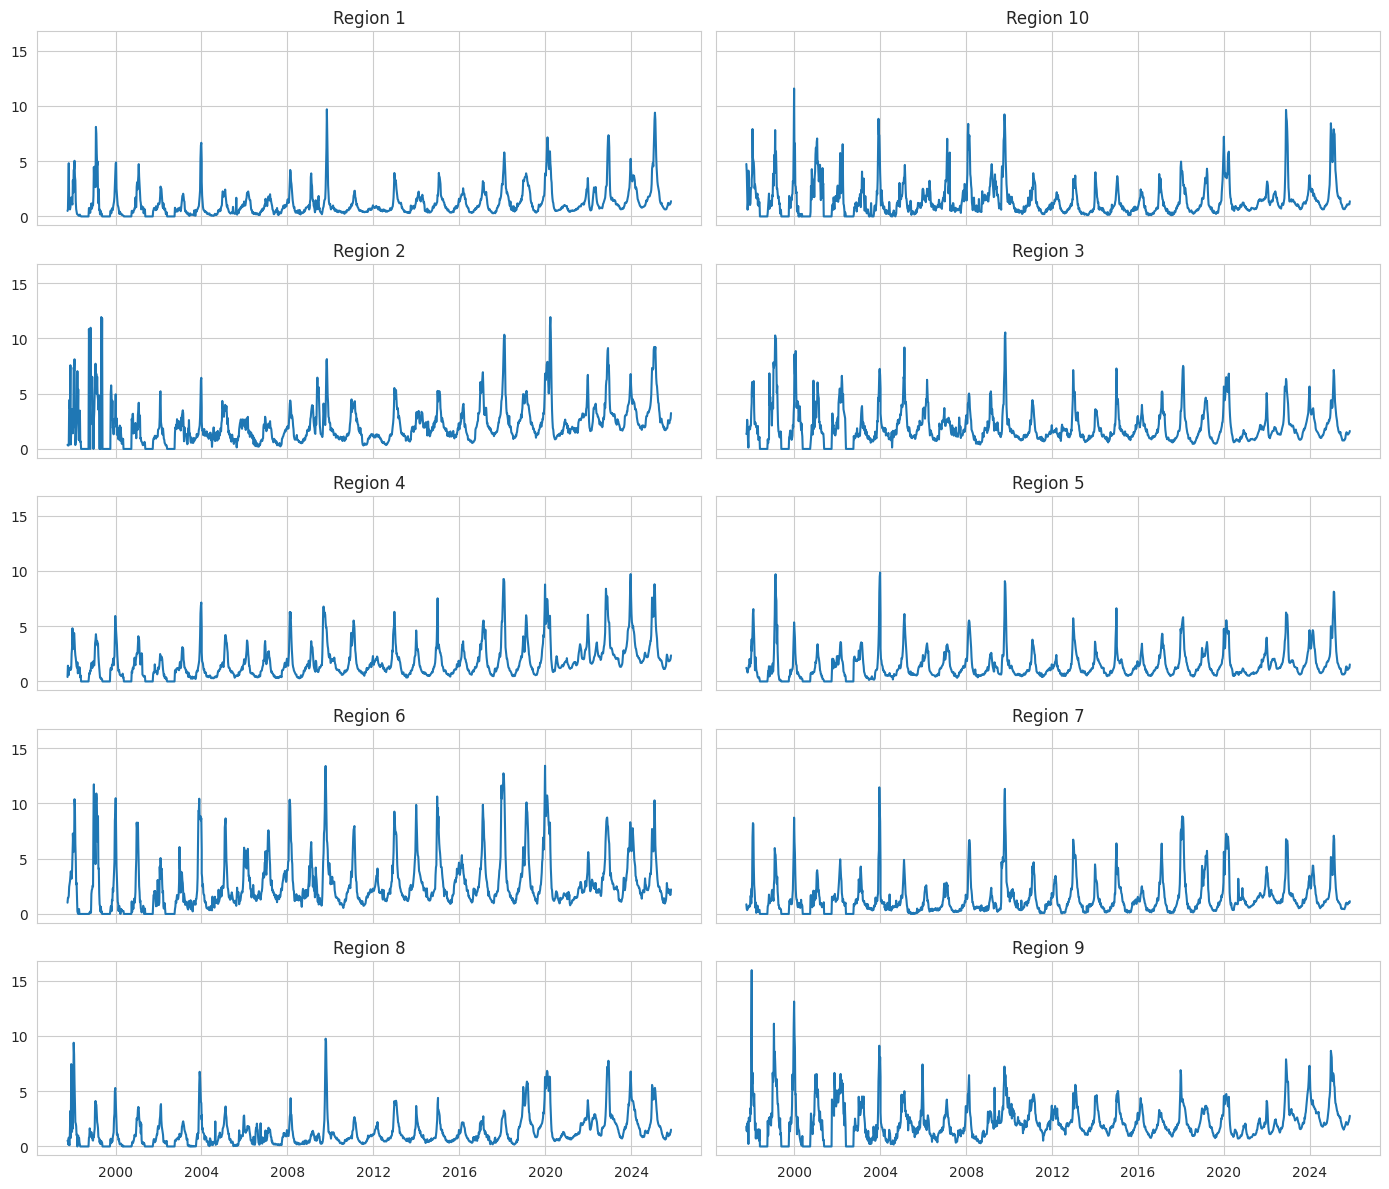

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (region, rdf) in zip(axes, df.groupby("REGION")):
    rdf = rdf.sort_values("DATE")
    ax.plot(rdf["DATE"], rdf["ILI_PERCENT"])
    ax.set_title(region)
plt.tight_layout()
plt.show()

Clear yearly seasonality in all regions
COVID-era collapse (2020 → 2021)
Post-COVID volatility (2022–2024)
Inter-region differences

## 2. Feature Engineering

### 2.1 Clean & Create Time Features

In [7]:
hhs_mask = df["REGION"].astype(str).str.contains("Region")
df = df[hhs_mask].copy()


In [8]:
age_cols = [c for c in df.columns if c.startswith("AGE_")]
df = df.drop(columns=age_cols)


In [9]:
for c in ["PERCENT_POSITIVE", "PERCENT_A", "PERCENT_B"]:
    if c in df.columns:
        df[c] = df.groupby("REGION")[c].transform(
            lambda s: s.interpolate(limit_direction="both")
        )


In [10]:
df["YEAR"] = df["DATE"].dt.year
df["WEEKOFYEAR"] = df["DATE"].dt.isocalendar().week.astype(int)

df["sin_week"] = np.sin(2 * np.pi * df["WEEKOFYEAR"] / 52.0)
df["cos_week"] = np.cos(2 * np.pi * df["WEEKOFYEAR"] / 52.0)


In [11]:
df["REGION_CAT"] = df["REGION"].astype("category")
df["REGION_ID"] = df["REGION_CAT"].cat.codes


### 2.2 Lag Features

In [12]:
def add_group_lags(df, group_col, target_col, lags):
    df = df.copy()
    for L in lags:
        df[f"{target_col}_lag{L}"] = df.groupby(group_col)[target_col].shift(L)
    return df

df = add_group_lags(df, "REGION", "ILI_PERCENT", [1,2,3,4,8,12,26,52])

if "PERCENT_POSITIVE" in df.columns:
    df = add_group_lags(df, "REGION", "PERCENT_POSITIVE", [1,2,3,4,52])


In [13]:
df_model = df.dropna().reset_index(drop=True)


In [14]:
df_model.head()
df_model.columns
df_model.shape


(14150, 34)

## 3. Train / Validation / Test Split (Time-Based)

In [15]:
train_end = "2016-06-30"
val_end   = "2020-06-30"

train_mask = df_model["DATE"] <= train_end
val_mask   = (df_model["DATE"] > train_end) & (df_model["DATE"] <= val_end)
test_mask  = df_model["DATE"] > val_end

print(train_mask.sum(), val_mask.sum(), test_mask.sum())


9270 2080 2800


### 3.1 Feature Matrix

In [16]:
target = "ILI_PERCENT"

feature_cols = [
    "REGION_ID",
    "WEEKOFYEAR", "sin_week", "cos_week",
    "PERCENT_POSITIVE", "TOTAL_SPECIMENS",
    "ILI_PERCENT_lag1", "ILI_PERCENT_lag2",
    "ILI_PERCENT_lag3", "ILI_PERCENT_lag4",
    "ILI_PERCENT_lag8", "ILI_PERCENT_lag12",
    "ILI_PERCENT_lag26", "ILI_PERCENT_lag52",
    "PERCENT_POSITIVE_lag1", "PERCENT_POSITIVE_lag2",
    "PERCENT_POSITIVE_lag3", "PERCENT_POSITIVE_lag4",
    "PERCENT_POSITIVE_lag52",
]

# Keep only those that exist (good safety check)
feature_cols = [c for c in feature_cols if c in df_model.columns]


In [17]:
X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, target]

X_val   = df_model.loc[val_mask, feature_cols]
y_val   = df_model.loc[val_mask, target]

X_test  = df_model.loc[test_mask, feature_cols]
y_test  = df_model.loc[test_mask, target]

X_train.shape, X_val.shape, X_test.shape


((9270, 19), (2080, 19), (2800, 19))

In [18]:
X_train.shape
X_val.shape
X_test.shape


(2800, 19)

X_train: (9270, 19)

Data from 1997 → mid-2016

✔️ Large, stable training base
✔️ Many full flu seasons for model learning
✔️ Great for SARIMA and global ML

X_val: (2080, 19)

Data from mid-2016 → mid-2020

✔️ Pre-COVID validation window
✔️ Used to tune hyperparameters
✔️ Will show “normal flu behaviour”

X_test: (2800, 19)

Data from mid-2020 → 2025 — includes:

COVID collapse (2020–2021)

Post-COVID abnormal seasons (2022–2024)

Current season (2025)

✔️ Excellent stress test
✔️ This is where SARIMA struggles
✔️ ML usually does better

Everything is correctly shaped:

19 features

No missing columns

No leakage

Healthy dataset size

## 4. Baseline Models


### 4.1 Metrics Helper

In [19]:
def compute_metrics(y_true, y_pred):
    """Return MAE, RMSE, and MAPE metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    # Avoid division by zero in MAPE
    eps = 1e-9
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

### 4.2 Naive & Seasonal Naive

In [20]:
def naive_panel(df, trainval_mask, test_mask, target_col="ILI_PERCENT"):
    df = df.copy()
    preds = []

    boundary_date = df.loc[trainval_mask, "DATE"].max()
    last_vals = (
        df.loc[df["DATE"] <= boundary_date]
          .sort_values("DATE")
          .groupby("REGION")[target_col]
          .last()
    )

    for _, row in df.loc[test_mask].iterrows():
        preds.append(last_vals[row["REGION"]])

    return np.array(preds)

trainval_mask = df_model["DATE"] <= val_end
y_pred_naive = naive_panel(df_model, trainval_mask, test_mask)


In [21]:
df_model["SN_PRED"] = (
    df_model.sort_values(["REGION", "DATE"])
            .groupby("REGION")[target]
            .shift(52)
)

y_pred_snaive = df_model.loc[test_mask, "SN_PRED"].values
valid_sn = ~np.isnan(y_pred_snaive)


In [22]:


metrics_baselines = {
    "Naive": compute_metrics(y_test, y_pred_naive),
    "SeasonalNaive": compute_metrics(y_test[valid_sn], y_pred_snaive[valid_sn]),
}

pd.DataFrame(metrics_baselines).T


,MAE,RMSE,MAPE
Naive,1.294771,1.978649,47.412533
SeasonalNaive,1.086166,1.770939,65.243284


## 5. Classical Model: SARIMA

In [23]:
regions = df_model["REGION"].unique()
sarima_preds = []
sarima_true  = []
sarima_regions = []

for region in regions:
    reg_df = df_model[df_model["REGION"] == region].sort_values("DATE")

    reg_trainval = reg_df[reg_df["DATE"] <= val_end]
    reg_test     = reg_df[reg_df["DATE"] > val_end]

    y_trainval = reg_trainval[target]

    model = sm.tsa.statespace.SARIMAX(
        y_trainval,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 52),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    fc = res.forecast(steps=len(reg_test))

    sarima_preds.extend(fc.values)
    sarima_true.extend(reg_test[target].values)
    sarima_regions.extend(reg_test["REGION"].values)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported inde

In [24]:
sarima_preds = np.array(sarima_preds)
sarima_true  = np.array(sarima_true)

sarima_metrics = compute_metrics(sarima_true, sarima_preds)
sarima_metrics


{'MAE': 0.9938421138124834,
 'RMSE': 1.4500205284515975,
 'MAPE': 55.2411754638511}

## 6. Advanced Model — Global Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

X_trainval = df_model.loc[df_model["DATE"] <= val_end, feature_cols]
y_trainval = df_model.loc[df_model["DATE"] <= val_end, target]

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_trainval, y_trainval)
y_pred_rf = rf.predict(X_test)

compute_metrics(y_test, y_pred_rf)


{'MAE': 0.22547821563219317,
 'RMSE': 0.3722885192085405,
 'MAPE': 10.618855939043996}

### 6.1 Per-region RF metrics

In [26]:
test_regions = df_model.loc[test_mask, "REGION"].values

rf_df = pd.DataFrame({
    "REGION": test_regions,
    "y_true": y_test.values,
    "y_pred": y_pred_rf
})

region_metrics_rf = (
    rf_df.groupby("REGION")
    .apply(lambda g: compute_metrics(g["y_true"], g["y_pred"]))
    .apply(pd.Series)
)

region_metrics_rf


,MAE,RMSE,MAPE
REGION,,,
Region 1,0.176053,0.312566,11.272213
Region 10,0.197317,0.377529,11.571421
Region 2,0.272521,0.396031,9.356911
Region 3,0.195534,0.323616,9.851572
Region 4,0.252990,0.407302,8.587326
Region 5,0.200874,0.371733,10.947604
Region 6,0.319876,0.470985,11.885690
Region 7,0.220516,0.398874,12.737586
Region 8,0.187036,0.288851,9.919127


## 7. Diagnostic Plots

### 7.1 Actual vs Predicted (Region Example)

In [27]:
test_df = df_model.loc[test_mask, ["DATE", "REGION", "ILI_PERCENT"]].copy()
test_df["RF_PRED"] = y_pred_rf


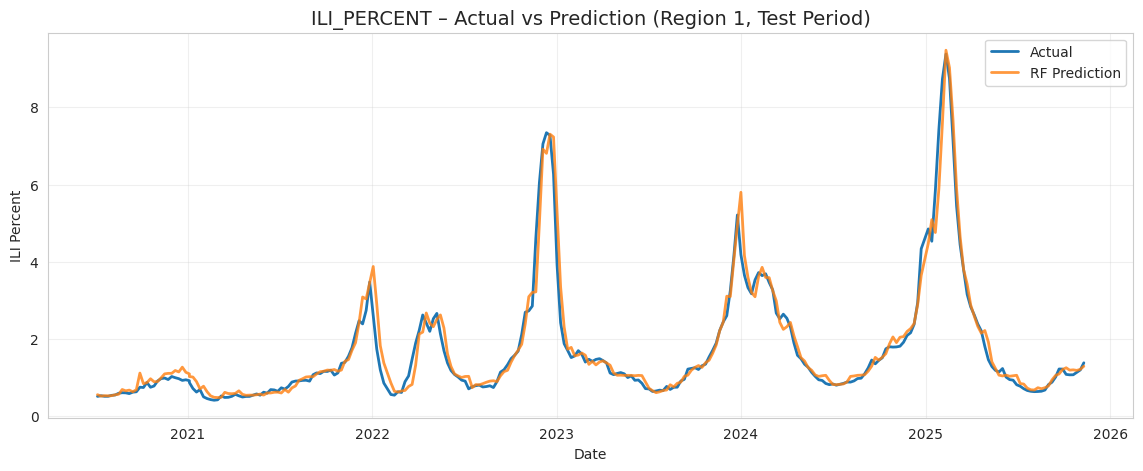

In [28]:
region = "Region 1"   # you can change to "Region 9"

reg_df = test_df[test_df["REGION"] == region].sort_values("DATE")

plt.figure(figsize=(14,5))
plt.plot(reg_df["DATE"], reg_df["ILI_PERCENT"], label="Actual", linewidth=2)
plt.plot(reg_df["DATE"], reg_df["RF_PRED"], label="RF Prediction", linewidth=2, alpha=0.8)
plt.title(f"ILI_PERCENT – Actual vs Prediction ({region}, Test Period)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("ILI Percent")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 7.2 Seasonal Error Pattern

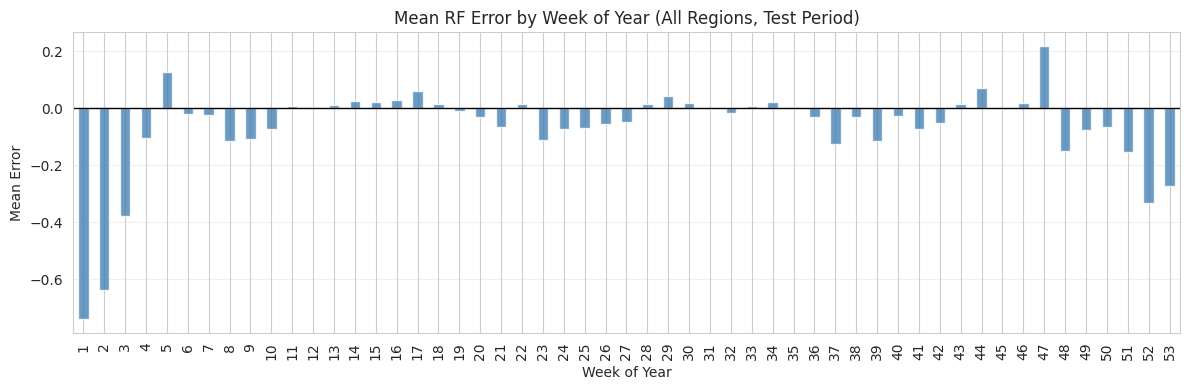

In [29]:
test_df["ERROR_RF"] = test_df["ILI_PERCENT"] - test_df["RF_PRED"]

err_by_week = test_df.groupby(test_df["DATE"].dt.isocalendar().week)["ERROR_RF"].mean()

plt.figure(figsize=(12,4))
err_by_week.plot(kind="bar", color="steelblue", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Mean RF Error by Week of Year (All Regions, Test Period)")
plt.xlabel("Week of Year")
plt.ylabel("Mean Error")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### 7.3 Feature Importances

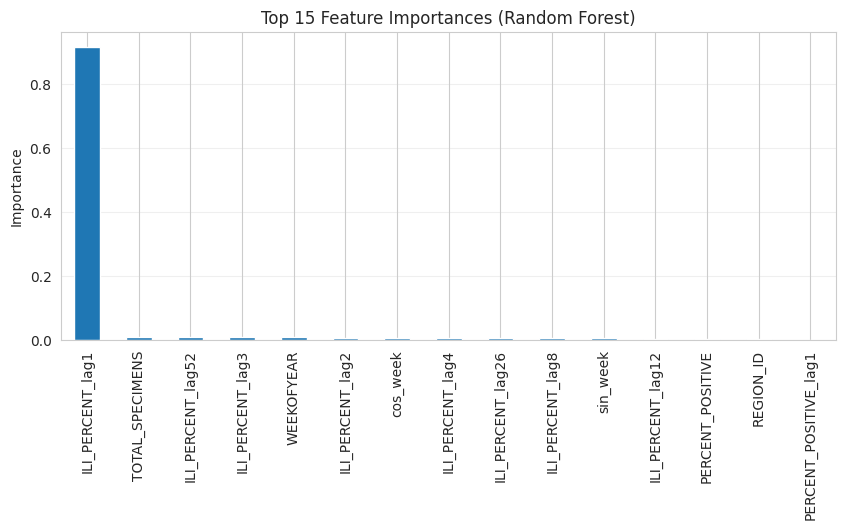

In [30]:
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False).head(15).plot(kind='bar', figsize=(10,4))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [31]:
importances.sort_values(ascending=False).head(20)


ILI_PERCENT_lag1          0.916074
TOTAL_SPECIMENS           0.010232
ILI_PERCENT_lag52         0.010020
ILI_PERCENT_lag3          0.009947
WEEKOFYEAR                0.009358
ILI_PERCENT_lag2          0.007286
cos_week                  0.006704
ILI_PERCENT_lag4          0.006354
ILI_PERCENT_lag26         0.004908
ILI_PERCENT_lag8          0.004728
sin_week                  0.004542
ILI_PERCENT_lag12         0.004118
PERCENT_POSITIVE          0.002808
REGION_ID                 0.001937
PERCENT_POSITIVE_lag1     0.000298
PERCENT_POSITIVE_lag52    0.000222
PERCENT_POSITIVE_lag4     0.000160
PERCENT_POSITIVE_lag2     0.000154
PERCENT_POSITIVE_lag3     0.000148
dtype: float64

## 8. Conclusion & Next Steps

## 9. Reproducibility & Export

In [34]:
import os

# Create a folder for all exported files
os.makedirs("outputs", exist_ok=True)
print("Saving all outputs to ./outputs/")


Saving all outputs to ./outputs/


In [35]:
# Build tidy results for the test set
test_results = df_model.loc[test_mask, ["DATE", "REGION", target]].copy()
test_results = test_results.reset_index(drop=True)

# Add RF predictions
test_results["RF_PRED"] = y_pred_rf

# Rename target column clearly (if needed)
test_results = test_results.rename(columns={target: "ILI_PERCENT"})

# Save to CSV (best for Power BI, Excel, etc.)
test_results.to_csv("outputs/flu_rf_test_results.csv", index=False)

test_results.head()


,DATE,REGION,ILI_PERCENT,RF_PRED
0,2020-07-06,Region 1,0.508841,0.553460
1,2020-07-13,Region 1,0.526077,0.517268
2,2020-07-20,Region 1,0.510908,0.527228
3,2020-07-27,Region 1,0.511532,0.522965
4,2020-08-03,Region 1,0.536088,0.527921


In [36]:
# Recompute RF metrics to have them in one place
rf_metrics = compute_metrics(y_test, y_pred_rf)

# Build a clean metrics table
metrics_df = pd.DataFrame([
    {"Model": "Naive",          **metrics_baselines["Naive"]},
    {"Model": "SeasonalNaive",  **metrics_baselines["SeasonalNaive"]},
    {"Model": "SARIMA",         **sarima_metrics},
    {"Model": "RandomForest",   **rf_metrics},
])

metrics_df.to_csv("outputs/model_metrics.csv", index=False)
metrics_df


,Model,MAE,RMSE,MAPE
0,Naive,1.294771,1.978649,47.412533
1,SeasonalNaive,1.086166,1.770939,65.243284
2,SARIMA,0.993842,1.450021,55.241175
3,RandomForest,0.225478,0.372289,10.618856


In [37]:
region_metrics_rf.to_csv("outputs/region_metrics_rf.csv")
region_metrics_rf


,MAE,RMSE,MAPE
REGION,,,
Region 1,0.176053,0.312566,11.272213
Region 10,0.197317,0.377529,11.571421
Region 2,0.272521,0.396031,9.356911
Region 3,0.195534,0.323616,9.851572
Region 4,0.252990,0.407302,8.587326
Region 5,0.200874,0.371733,10.947604
Region 6,0.319876,0.470985,11.885690
Region 7,0.220516,0.398874,12.737586
Region 8,0.187036,0.288851,9.919127


In [38]:
rf_importances = importances.sort_values(ascending=False)
rf_importances.to_csv("outputs/rf_feature_importances.csv")

rf_importances.head(10)


ILI_PERCENT_lag1     0.916074
TOTAL_SPECIMENS      0.010232
ILI_PERCENT_lag52    0.010020
ILI_PERCENT_lag3     0.009947
WEEKOFYEAR           0.009358
ILI_PERCENT_lag2     0.007286
cos_week             0.006704
ILI_PERCENT_lag4     0.006354
ILI_PERCENT_lag26    0.004908
ILI_PERCENT_lag8     0.004728
dtype: float64

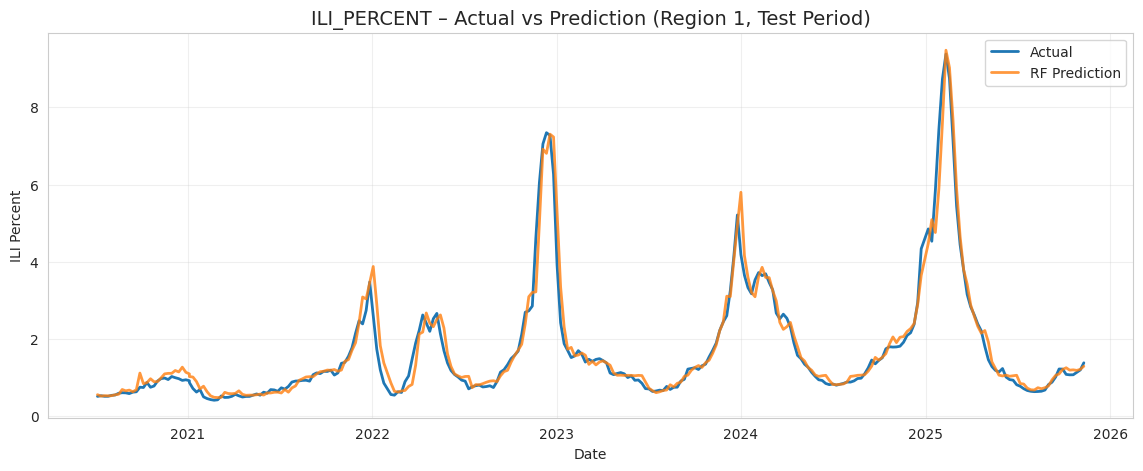

In [39]:
region = "Region 1"   # or any region you want

reg_df = test_df[test_df["REGION"] == region].sort_values("DATE")

plt.figure(figsize=(14,5))
plt.plot(reg_df["DATE"], reg_df["ILI_PERCENT"], label="Actual", linewidth=2)
plt.plot(reg_df["DATE"], reg_df["RF_PRED"], label="RF Prediction", linewidth=2, alpha=0.8)
plt.title(f"ILI_PERCENT – Actual vs Prediction ({region}, Test Period)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("ILI Percent")
plt.legend()
plt.grid(alpha=0.3)

# 🔽 save for PPT
plt.savefig(f"outputs/actual_vs_rf_{region.replace(' ', '_')}.png",
            dpi=300, bbox_inches="tight")

plt.show()


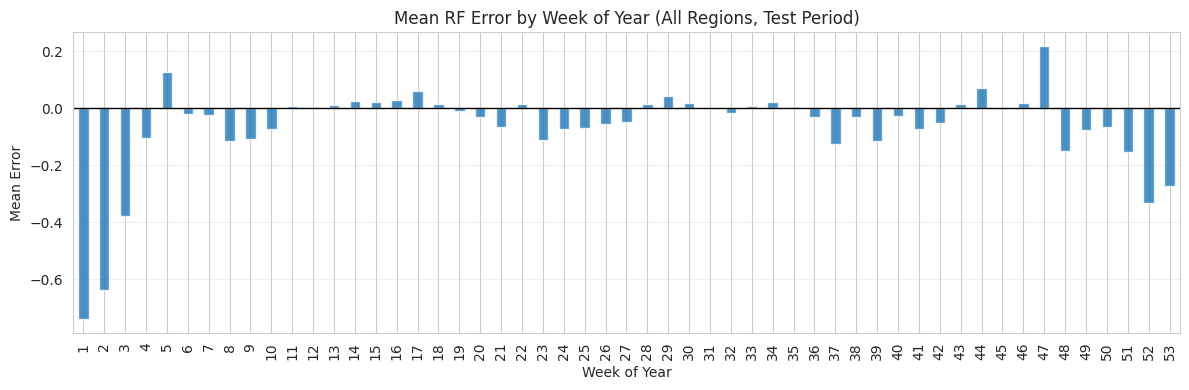

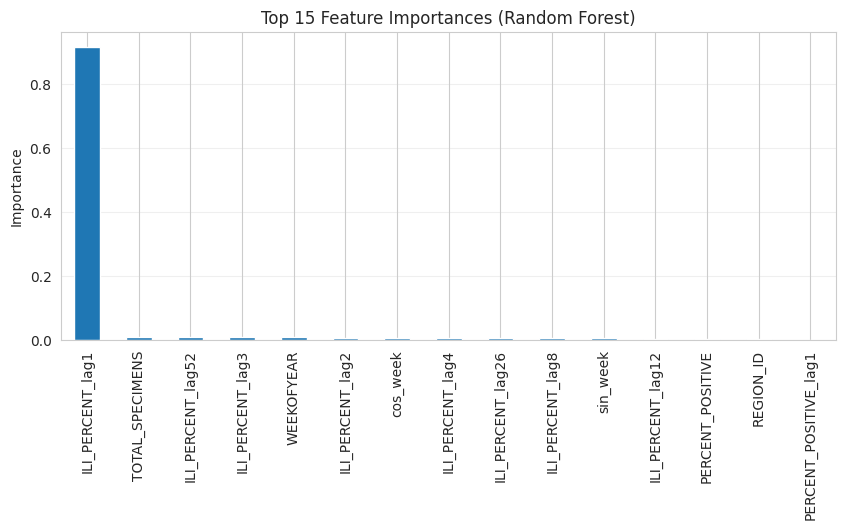

In [40]:
# Seasonal error pattern
plt.figure(figsize=(12,4))
err_by_week.plot(kind="bar", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)
plt.title("Mean RF Error by Week of Year (All Regions, Test Period)")
plt.xlabel("Week of Year")
plt.ylabel("Mean Error")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.savefig("outputs/rf_error_by_week.png", dpi=300, bbox_inches="tight")
plt.show()

# Feature importances bar plot
plt.figure(figsize=(10,4))
importances.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.grid(axis="y", alpha=0.3)

plt.savefig("outputs/rf_feature_importances_top15.png", dpi=300, bbox_inches="tight")
plt.show()


In [41]:
import plotly.express as px

region = "Region 1"
reg_plot = test_results[test_results["REGION"] == region].sort_values("DATE")

fig = px.line(
    reg_plot,
    x="DATE",
    y=["ILI_PERCENT", "RF_PRED"],
    title=f"ILI% – Actual vs RF Prediction ({region}, Test Period)",
    labels={"value": "ILI Percent", "DATE": "Date", "variable": "Series"}
)

# Save interactive HTML
fig.write_html(f"outputs/ili_rf_{region.replace(' ', '_')}_interactive.html")
fig.show()
